# Milestone 3: Sea Ice Concentration Climatology
> Author: Tien Ly  
> Created: July 2024

## Objective
This notebook, a part of milestone 3 of my internship at NOAA PolarWatch, is focused on analyzing weekly sea ice concentration (SIC) data for the year 2023 and comparing it with historical climatology from 2006 to 2020. The analysis is structured to address key research questions:

1. **Data Preprocessing and Weekly Climatology Calculation**: How can we compute the weekly climatology of SIC from daily data over the period 2006-2020, despite computational limitations?

2. **Weekly Sea Ice Concentration Comparison: 2023 vs. Climatology**: How does weekly SIC in 2023 compare against the historical climatology? Are there specific weeks where SIC in 2023 significantly deviates from the climatology?

3. **Identifying Anomalies and Trends in 2023**: What are the temporal patterns of anomalies in SIC for 2023, and what trends can be detected using the Mann-Kendall test?

4. **Statistical Analysis**: Which weeks in 2023 show significant differences from the climatological norm, as determined by a statistical t-test?

5. **Mapping Anomalies**: What do the spatial patterns of SIC anomalies look like for the week with the most significant deviation from the climatology?

This notebook provides a comprehensive analysis of sea ice concentration, highlighting significant deviations and trends, which can help in understanding the ongoing changes in the Arctic sea ice environment.

### Dataset used
Sea Ice Concentration, NOAA/NSIDC Climate Data Record V4, Northern Hemisphere, 25km, Science Quality, 1978-Present, Daily
https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nh1day.graph


## Import libraries

In [ ]:
# Uncomment and run if pymannkendall is not installed in your environment
# %pip install pymannkendall

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pymannkendall as mk
from scipy.stats import t
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')

## Part 1: Data Preprocessing and Weekly Climatology Calculation

### Get the daily SIC data from ERDDAP

In [2]:
# Open the dataset in xarray
url = 'https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nh1day'
ds = xr.open_dataset(url)
ds

<xarray.Dataset> Size: 72GB
Dimensions:                         (time: 16507, ygrid: 448, xgrid: 304)
Coordinates:
  * time                            (time) datetime64[ns] 132kB 1978-10-25 .....
  * ygrid                           (ygrid) float32 2kB 5.838e+06 ... -5.338e+06
  * xgrid                           (xgrid) float32 1kB -3.838e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc                 (time, ygrid, xgrid) float32 9GB ...
    melt_onset_day_cdr_seaice_conc  (time, ygrid, xgrid) float32 9GB ...
    nsidc_bt_seaice_conc            (time, ygrid, xgrid) float32 9GB ...
    nsidc_nt_seaice_conc            (time, ygrid, xgrid) float32 9GB ...
    qa_of_cdr_seaice_conc           (time, ygrid, xgrid) float32 9GB ...
    spatial_interpolation_flag      (time, ygrid, xgrid) float32 9GB ...
    stdev_of_cdr_seaice_conc        (time, ygrid, xgrid) float32 9GB ...
    temporal_interpolation_flag     (time, ygrid, xgrid) float32 9GB ...
Attributes: (12/65)
    _NCProperties:                                       version=2,netcdf=4.8...
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1D
    time_coverage_end:                                   2024-03-31T00:00:00Z
    time_coverage_resolution:                            P1D
    time_coverage_start:                                 1978-10-25T00:00:00Z
    title:                                               Sea Ice Concentratio...

In [3]:
# Extract the SIC data from the dataset
da_sic = ds['cdr_seaice_conc']
da_sic

<xarray.DataArray 'cdr_seaice_conc' (time: 16507, ygrid: 448, xgrid: 304)> Size: 9GB
[2248121344 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 132kB 1978-10-25 1978-10-26 ... 2024-03-31
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Attributes: (12/13)
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    colorBarMaximum:      1.0
    colorBarMinimum:      0.0
    colorBarPalette:      KT_ice
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    ...                   ...
    ioos_category:        Ice Distribution
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    references:           https://nsidc.org/data/g02202/versions/4/
    standard_name:        sea_ice_area_fraction
    units:                1
    valid_range:          [0. 1.]

#### Print out some useful metadata

In [4]:
print('Dimensions:', list(da_sic.dims))
print('Coordinates:', list(da_sic.coords))

Dimensions: ['time', 'ygrid', 'xgrid']
Coordinates: ['time', 'ygrid', 'xgrid']


In [5]:
print('Earliest date:', da_sic.time.values[0])
print('Most recent date:', da_sic.time.values[-1])

Earliest date: 1978-10-25T00:00:00.000000000
Most recent date: 2024-03-31T00:00:00.000000000


In [6]:
print("Is xgrid's first value -->", round(da_sic.xgrid[0].item(), 6))
print('greater than') 
print("xgrid's last value -->", round(da_sic.xgrid[-1].item(), 6))

print(da_sic.xgrid[0].item() > da_sic.xgrid[-1].item())

Is xgrid's first value --> -3837500.0
greater than
xgrid's last value --> 3737500.0
False


In [7]:
print("Is ygrid's first value -->", round(da_sic.ygrid[0].item(), 6))
print('greater than') 
print("ygrid's last value -->", round(da_sic.ygrid[-1].item(), 6))

print(da_sic.ygrid[0].item() > da_sic.ygrid[-1].item())

Is ygrid's first value --> 5837500.0
greater than
ygrid's last value --> -5337500.0
True


###  Compute the weekly means for the 2006-2020 climatological period from daily data

In [8]:
# Extract the dataset for the climatological period: 2006-2020
start_date = '2006-01-01'
end_date = '2020-12-31'
da_sic_bl = da_sic.sel(time=slice(start_date, end_date))
da_sic_bl

<xarray.DataArray 'cdr_seaice_conc' (time: 5391, ygrid: 448, xgrid: 304)> Size: 3GB
[734211072 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 43kB 2006-01-01 2006-01-02 ... 2020-12-31
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Attributes: (12/13)
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    colorBarMaximum:      1.0
    colorBarMinimum:      0.0
    colorBarPalette:      KT_ice
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    ...                   ...
    ioos_category:        Ice Distribution
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    references:           https://nsidc.org/data/g02202/versions/4/
    standard_name:        sea_ice_area_fraction
    units:                1
    valid_range:          [0. 1.]

**Note:** Since my laptop can't process the entire DataArray at once, I handle the data week by week. While the ideal method to compute the weekly climatology would be to use `da_sic_bl.groupby('time.week').mean(dim='time')` (after filtering out flag values), this approach is not feasible due to data size constraints. Instead, I compute the mean SIC for each week within the climatology period separately, then group these weekly means together. Finally, I average these grouped weekly means to estimate the weekly climatology. This method should yield similar results to the direct approach, given the constraints.

In [9]:
# Create a range of weekly periods across 2006-2020
weekly_periods = pd.date_range(start=start_date, end=end_date, freq='W-MON')
# Adjust the start date of the first weekly period to 2006-01-01 instead of 2006-01-02
weekly_periods = pd.DatetimeIndex([weekly_periods[0] - pd.DateOffset(days=1)] + list(weekly_periods[1:]))
weekly_periods

DatetimeIndex(['2006-01-01', '2006-01-09', '2006-01-16', '2006-01-23',
               '2006-01-30', '2006-02-06', '2006-02-13', '2006-02-20',
               '2006-02-27', '2006-03-06',
               ...
               '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
               '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
               '2020-12-21', '2020-12-28'],
              dtype='datetime64[ns]', length=783, freq=None)

**Note:** The sea ice concentration values range from 0 (no ice cover) to 1 (100% ice cover). However, this dataset also includes values above 1 to flag features like lakes, coastline, and land. Therefore, we need to remove those flag values.

In [14]:
weekly_means = []

# Iterate over each weekly period
for i in range(len(weekly_periods)):
    # Define the current week
    week_start = weekly_periods[i]
    if i == len(weekly_periods) - 1: # for the last weekly period
        week_end = pd.to_datetime(datetime.date(2020, 12, 31))
    else:
        week_end = weekly_periods[i + 1] - pd.DateOffset(days=1)
    
    # Extract the current week
    da_sic_weekly = da_sic_bl.sel(time=slice(week_start, week_end))
    
    # Filter out the flag values, keeping only valid SIC values
    da_sic_weekly = da_sic_weekly.where(da_sic_weekly <= 1, drop=True)
    
    # Calculate the weekly mean
    weekly_mean = da_sic_weekly.mean(dim='time')
    weekly_means.append(weekly_mean)

print(len(weekly_means))
print(weekly_means[0])

783
<xarray.DataArray 'cdr_seaice_conc' (ygrid: 448, xgrid: 304)> Size: 545kB
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06


In [18]:
# Concatenate the weekly means list into a single DataArray
final_weekly_means = xr.concat(weekly_means, dim='time')
# Assign the time coordinate to the DataArray
final_weekly_means = final_weekly_means.assign_coords(time=weekly_periods)
final_weekly_means

<xarray.DataArray 'cdr_seaice_conc' (time: 783, ygrid: 448, xgrid: 304)> Size: 427MB
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * time     (time) datetime64[ns] 6kB 2006-01-01 2006-01-09 ... 2020-12-28

In [19]:
# Compute the weekly climatology (2006-2020)
weekly_climatology = final_weekly_means.groupby('time.week').mean(dim='time')
weekly_climatology

/Users/tienly/opt/miniconda3/envs/polarwatch/lib/python3.9/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


<xarray.DataArray 'cdr_seaice_conc' (week: 53, ygrid: 448, xgrid: 304)> Size: 29MB
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * week     (week) int64 424B 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53

In [20]:
# Save the DataArrays to a NetCDF file for later sessions
# since the climatology computation is time-consuming
final_weekly_means.to_netcdf('da_weekly_means.nc')
weekly_climatology.to_netcdf('da_clim.nc')

## Part 2: Weekly Sea Ice Concentration Comparison: 2023 vs. Climatology (2006-2020)

This section compares weekly sea ice concentration values for 2023 against the historical climatology (2006-2020).

### Calculate the weekly means for 2023

In [10]:
# Select the 2023 data
da_sic_2023 = da_sic.sel(time=slice('2023-01-01', '2023-12-31'))
# Filter out the flag values
da_sic_2023 = da_sic_2023.where(da_sic_2023 <= 1, drop=True)

In [11]:
# Compute the 2023 weekly means
da_23 = da_sic_2023.groupby('time.week').mean('time')
da_23

<xarray.DataArray 'cdr_seaice_conc' (week: 52, ygrid: 448, xgrid: 304)> Size: 28MB
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * week     (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Attributes: (12/13)
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    colorBarMaximum:      1.0
    colorBarMinimum:      0.0
    colorBarPalette:      KT_ice
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    ...                   ...
    ioos_category:        Ice Distribution
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    references:           https://nsidc.org/data/g02202/versions/4/
    standard_name:        sea_ice_area_fraction
    units:                1
    valid_range:          [0. 1.]

### Load the weekly climatology

In [12]:
# Load the weekly climatology from the NetCDF file (in a new session)
da_clim = xr.open_dataarray('da_clim.nc')

**Note:** Since the weekly climatology array has 53 weeks, while the 2023 weekly mean array has 52 weeks, I drop the last week from the climatology array.

In [13]:
print('Number of weeks of the climatology array:', len(da_clim.week))
print('Number of weeks of the 2023 array:', len(da_23.week))

Number of weeks of the climatology array: 53
Number of weeks of the 2023 array: 52


In [14]:
da_clim = da_clim.isel(week=~(da_clim.week == 53))
da_clim

<xarray.DataArray 'cdr_seaice_conc' (week: 52, ygrid: 448, xgrid: 304)> Size: 28MB
[7081984 values with dtype=float32]
Coordinates:
  * ygrid    (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid    (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * week     (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52

###  Plot the comparison between 2023 weekly means and the climatology

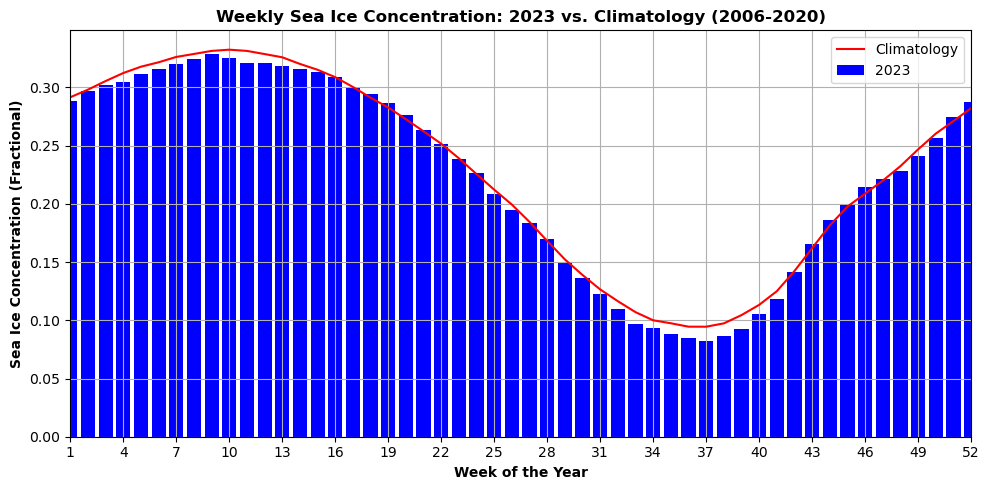

In [15]:
# Compute the spatial means
clim_mean = da_clim.mean(dim=['ygrid', 'xgrid'])
cur_mean = da_23.mean(dim=['ygrid', 'xgrid'])

plt.figure(figsize = (10, 5))
# Plot the climatology
plt.plot(clim_mean.week, clim_mean, label='Climatology', color='r')
# Plot the 2023 weekly means
plt.bar(cur_mean.week, cur_mean, label='2023', color='b')

# Customize the plot
plt.grid()
plt.legend()

plt.xlim([1, 52])
plt.xticks(ticks=clim_mean.week[::3])
plt.ylim(bottom=0)

plt.xlabel('Week of the Year', fontweight='bold')
plt.ylabel('Sea Ice Concentration (Fractional)', fontweight='bold')
plt.title('Weekly Sea Ice Concentration: 2023 vs. Climatology (2006-2020)', fontweight='bold')

plt.tight_layout()

## Part 3: 2023 Sea Ice Concentration: Identifying Anomalies and Trends

### Plot SIC anomalies

In this section, we visualize the anomalies in SIC for 2023 compared to the 2006-2020 climatology. Anomalies are computed as the difference between the 2023 weekly means and the climatological averages.

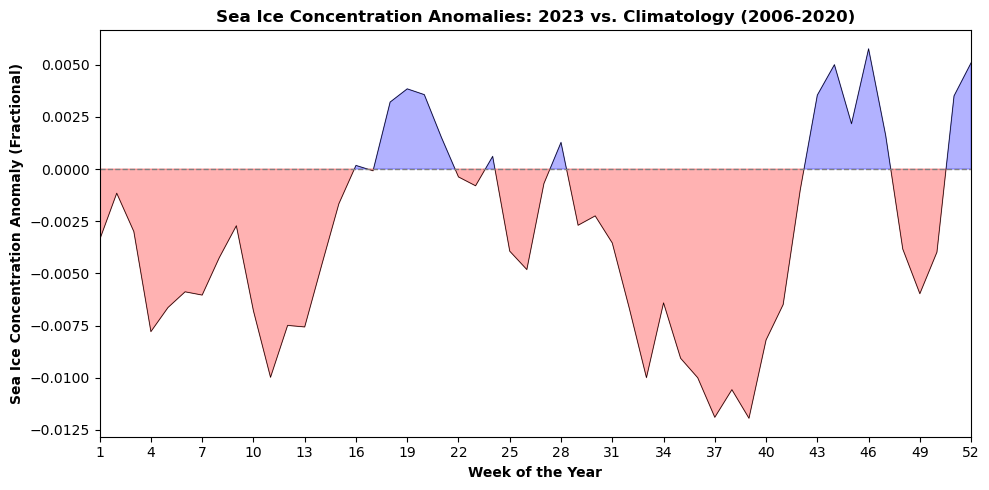

In [21]:
# Calculate anomalies (difference between 2023 weekly means and climatology)
anom_mean = cur_mean - clim_mean

plt.figure(figsize = (10, 5))
# Plot the anomalies over time
plt.plot(anom_mean.week, anom_mean, color='black', linewidth=0.5)
# Fill the area under the curve
plt.fill_between(anom_mean.week, 0, anom_mean, where=(anom_mean >= 0), interpolate=True, color='blue', alpha=0.3)
plt.fill_between(anom_mean.week, 0, anom_mean, where=(anom_mean <= 0), interpolate=True, color='red', alpha=0.3)
# Add a horizontal line at y = 0 for reference (zero anomaly)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Customize the plot
plt.xlim([1, 52])
plt.xticks(ticks=clim_mean.week[::3])

plt.xlabel('Week of the Year', fontweight='bold')
plt.ylabel('Sea Ice Concentration Anomaly (Fractional)', fontweight='bold')
plt.title('Sea Ice Concentration Anomalies: 2023 vs. Climatology (2006-2020)', fontweight='bold')

plt.tight_layout()

### Plot Mann-Kendall test trend data

In this section, we analyze SIC trends for 2023 using the Mann-Kendall test. The Mann-Kendall test assesses whether there is a statistically significant trend (increasing, decreasing, or no trend) over time at each grid cell. This plot helps in understanding spatial patterns of sea ice concentration trends throughout 2023.

In [21]:
# Initialize an empty list to store trend results
trends = []
# Define possible trend outcomes from the Mann-Kendall test
possible_trends = ['decreasing', 'no trend', 'increasing']

# Loop through each grid cell in the ygrid and xgrid dimensions
for i in np.arange(len(da_23.ygrid.values)):
  for j in np.arange(len(da_23.xgrid.values)):
    try:
      # Apply the Mann-Kendall trend test to the time series at each grid cell
      trend = mk.original_test(da_23[:, i, j]).trend
    except:
      # In case of an error, assign a placeholder value
      trend = -9999
    trends.append(trend)

# Reshape the flat trends list into a 2D array matching the ygrid and xgrid dimensions
trends = np.array(trends).reshape(da_23.ygrid.size, da_23.xgrid.size)

# Convert trend outcomes to numerical values
trends[trends == possible_trends[0]] = -1  # 'decreasing' -> -1
trends[trends == possible_trends[1]] = 0   # 'no trend' -> 0
trends[trends == possible_trends[2]] = 1   # 'increasing' -> 1
# Convert the trends array to integer type
trends = trends.astype(int)

# trends now contains the trend results for each grid cell, with:
# -1 indicating a decreasing trend,
#  0 indicating no trend,
#  1 indicating an increasing trend,
# -9999 indicating an error in the trend calculation
trends

array([[    0,     0,     0, ..., -9999, -9999, -9999],
       [    0,     0,     0, ..., -9999, -9999, -9999],
       [    0,     0,     0, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ...,     0,     0,     0],
       [-9999, -9999, -9999, ...,     0,     0,     0],
       [-9999, -9999, -9999, ...,     0,     0,     0]])

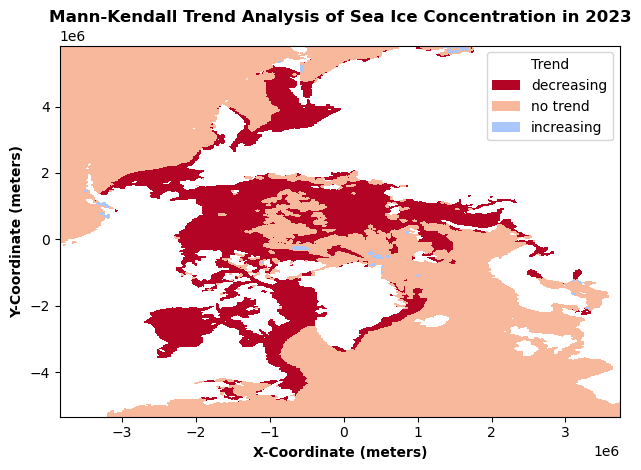

In [22]:
# Create an xarray DataArray from the trends array
mk_trends = xr.DataArray(trends, dims=('ygrid', 'xgrid'),
                         coords={'ygrid': da_23.ygrid, 'xgrid': da_23.xgrid},
                         name='trend')

# Plot the trend data using contourf
cs = mk_trends.where(mk_trends > -9999).plot.contourf(
    cmap='coolwarm_r',
    levels=[-2, -1, 0, 1, 2],  # Define contour levels to align with trend categories
    add_colorbar=False
)

# Customize the plot
artists, labels = cs.legend_elements()
plt.legend(handles=artists, labels=possible_trends, title='Trend')

plt.xlabel('X-Coordinate (meters)', fontweight='bold')
plt.ylabel('Y-Coordinate (meters)', fontweight='bold')
plt.title('Mann-Kendall Trend Analysis of Sea Ice Concentration in 2023', fontweight='bold')

plt.tight_layout()

## Part 4: Statistical Analysis

In this section, I want to identify weeks that show significant differences from the climatology. So I perform a t-test to determine significance.

### Calculate the weekly standard deviations for 2023

In [17]:
# Compute the 2023 weekly standard deviations
da_23_std = da_sic_2023.groupby('time.week').std('time')
# Compute the spatial means of the standard deviations across 'ygrid' and 'xgrid'
cur_std = da_23_std.mean(dim=['ygrid', 'xgrid'])
cur_std

<xarray.DataArray 'cdr_seaice_conc' (week: 52)> Size: 208B
array([0.01077271, 0.00999749, 0.01015999, 0.01067677, 0.0115708 ,
       0.01224857, 0.01076174, 0.01222103, 0.01200547, 0.01108389,
       0.0108297 , 0.00917931, 0.00871947, 0.0081511 , 0.00889988,
       0.00956147, 0.00905378, 0.00860508, 0.00881575, 0.01007905,
       0.01112213, 0.01141696, 0.01256111, 0.01354588, 0.01346758,
       0.01206502, 0.01133582, 0.01230158, 0.01225605, 0.01096638,
       0.01272414, 0.01116785, 0.00883918, 0.006558  , 0.00644052,
       0.00688193, 0.00647193, 0.00623201, 0.00811418, 0.00898958,
       0.00901313, 0.01436857, 0.01365004, 0.00987149, 0.00981372,
       0.01014946, 0.00916789, 0.01137862, 0.01284853, 0.01479663,
       0.01253594, 0.01520054], dtype=float32)
Coordinates:
  * week     (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52

### Perform two-tailed one-sample t-test and identify significant weeks

In [18]:
# Initialize lists to store results
p_values = []

# cur_mean: 2023 weekly means
# clim_mean: climatological weekly means
# Loop through each week
for i in range(len(cur_mean)):
    # Calculate the t-statistic
    t_stat = (cur_mean[i] - clim_mean[i]) / (cur_std[i] / np.sqrt(7))
    
    # Calculate the degrees of freedom
    degrees_of_freedom = 7 - 1
    
    # Calculate the p-value
    p_value = (1 - t.cdf(abs(t_stat), df=degrees_of_freedom)) * 2
    
    # Store the p-value
    p_values.append(p_value)

# Convert p-values to an array
p_values = np.array(p_values)

# Determine significant weeks
alpha = 0.05
significant_weeks = np.where(p_values < alpha)[0]

# Print weeks that show significant differences from the climatology
if len(significant_weeks) > 0:
    print(f'Weeks showing significant differences from the climatology (alpha = {alpha}):')
    for week in significant_weeks:
        print(f'{week + 1}')
else:
    print('No weeks show significant differences from the climatology.')


Weeks showing significant differences from the climatology (alpha = 0.05):
33
34
35
36
37
38
39


## Part 5: Mapping anomalies

In this section, we first find the week with the largest absolute anomaly and its value. Then we create 2 plots to visualize our data:

1. The 1st plot shows the sea ice concentration for the climatology dataset during the selected week. This plot provides a reference to the typical sea ice conditions for that week over the climatology period.

2. The second plot displays the anomalies for the same week, highlighting deviations from the climatology.

In [19]:
# Compute absolute values of anomalies
abs_anom_mean = np.abs(anom_mean)
# Find the index of the maximum absolute value
max_idx = abs_anom_mean.argmax()

# Retrieve the week number and the corresponding maximum absolute anomaly value
max_week = anom_mean.week[max_idx].item()
max_abs = abs_anom_mean[max_idx].item()

# Print results
print(f'The week with the largest absolute anomaly is: Week {max_week}')
print(f'The maximum absolute anomaly value is: {max_abs}')

The week with the largest absolute anomaly is: Week 39
The maximum absolute anomaly value is: 0.011943072080612183


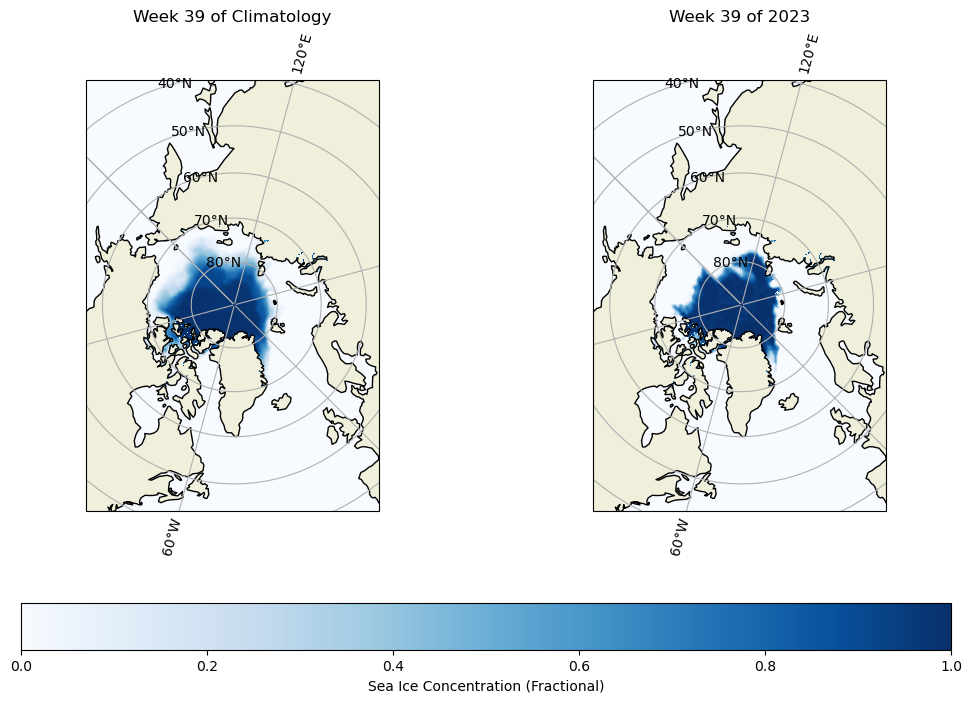

In [22]:
# Set the data projection using EPSG Code 
data_crs = ccrs.epsg('3411')
# Set the mapping projection to cartopy's North Polar Stereographic
crs_epsg = ccrs.NorthPolarStereo(central_longitude=-45)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), subplot_kw={'projection': crs_epsg}, sharex=True, sharey=True)
# Customize both subplots
for ax in [ax1, ax2]:
    ax1.set_extent([-3850000.0, 3750000.0, -5350000, 5850000.0], crs_epsg)
    ax.add_feature(cfeature.LAND)
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=True)

# Plot data on each subplot
im1 = ax1.pcolormesh(da_clim.xgrid, da_clim.ygrid, da_clim.isel(week=38), cmap=plt.cm.Blues, transform=data_crs)
im2 = ax2.pcolormesh(da_23.xgrid, da_23.ygrid, da_23.isel(week=38), cmap=plt.cm.Blues, transform=data_crs)
ax1.set_title('Week 39 of Climatology')
ax2.set_title('Week 39 of 2023')

# Add colorbar for both subplots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', label='Sea Ice Concentration (Fractional)')

plt.show()

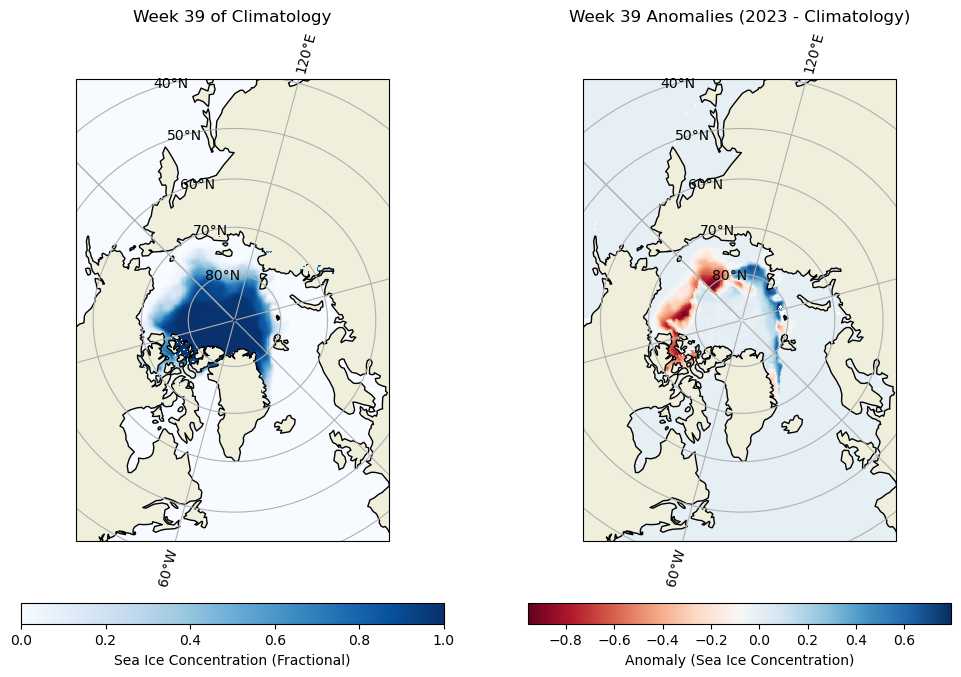

In [23]:
# Compute anomalies
da_anom = da_23 - da_clim

# Set the data projection using EPSG Code 
data_crs = ccrs.epsg('3411')
# Set the mapping projection to cartopy's North Polar Stereographic
crs_epsg = ccrs.NorthPolarStereo(central_longitude=-45)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), subplot_kw={'projection': crs_epsg}, sharex=True, sharey=True)
# Customize both subplots
for ax in [ax1, ax2]:
    ax.set_extent([-3850000.0, 3750000.0, -5350000, 5850000.0], crs_epsg)
    ax.add_feature(cfeature.LAND)
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=True)

# Plot data on each subplot
im1 = ax1.pcolormesh(da_clim.xgrid, da_clim.ygrid, da_clim.isel(week=38), cmap=plt.cm.Blues, transform=data_crs)
im2 = ax2.pcolormesh(da_anom.xgrid, da_anom.ygrid, da_anom.isel(week=38), cmap=plt.cm.RdBu, transform=data_crs)

# Set titles for the subplots
ax1.set_title('Week 39 of Climatology')
ax2.set_title('Week 39 Anomalies (2023 - Climatology)')

# Add separate colorbars for each subplot
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.1, label='Sea Ice Concentration (Fractional)')
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.1, label='Anomaly (Sea Ice Concentration)')

plt.show()